In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [12]:
def extract_carbon_data_from_calibration(cal_file_path):
    """
    Extract carbon data from the calibration CSV file for regression.
    
    Parameters:
    -----------
    cal_file_path : str
        Path to the calibration CSV file
    
    Returns:
    --------
    tuple: (weights, areas, slope, intercept, r_squared)
    """
    # Read the CSV file
    df = pd.read_csv(cal_file_path, header=None, skip_blank_lines=True)
    
    # Filter rows with Carbon data (Compound Name is 'Carbon')
    carbon_data = df[df[9] == 'Carbon']
    
    # Extract weight and area values
    weights = carbon_data[6].astype(float)
    areas = carbon_data[5].astype(float)
    
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(weights, areas)
    
    return weights, areas, slope, intercept, r_value**2

# Calibration Visualization
def plot_calibration_curve(weights, areas, slope, intercept, r_squared):
    """
    Create a calibration plot with regression line.
    
    Parameters:
    -----------
    weights : array-like
        Carbon weights
    areas : array-like
        Carbon peak areas
    slope : float
        Regression line slope
    intercept : float
        Regression line intercept
    r_squared : float
        R-squared value of the regression
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(weights, areas, color='blue', label='Calibration Points')
    
    # Create regression line
    line_x = np.array([weights.min(), weights.max()])
    line_y = slope * line_x + intercept
    plt.plot(line_x, line_y, color='red', label='Regression Line')
    
    plt.title('Carbon Calibration: Area vs Weight')
    plt.xlabel('Carbon Weight [mg]')
    plt.ylabel('Peak Area [mV.s]')
    
    # Add regression equation and R-squared to the plot
    equation = f'y = {slope:.4f}x + {intercept:.4f}'
    r_squared_text = f'R² = {r_squared:.4f}'
    plt.annotate(f'{equation}\n{r_squared_text}', 
                 xy=(0.05, 0.95), 
                 xycoords='axes fraction',
                 verticalalignment='top')
    
    plt.legend()
    plt.grid(True)
    plt.show()

# Sample Data Processing
def quantify_carbon_in_samples(data_file_path, slope, intercept):
    """
    Quantify carbon in samples using the calibration line.
    
    Parameters:
    -----------
    data_file_path : str
        Path to the data CSV file
    slope : float
        Slope of the calibration line
    intercept : float
        Intercept of the calibration line
    
    Returns:
    --------
    pandas.DataFrame: Quantified carbon data
    """
    # Read the data file
    df = pd.read_csv(data_file_path, header=None, skip_blank_lines=True)
    
    # Prepare results list
    results = []
    
    # Process each unique primary file
    unique_files = df[0].unique()
    
    for file_num in unique_files:
        # Filter rows for this file with Carbon data
        file_data = df[(df[0] == file_num) & (df[9].isin(['Carbon', 'Free ']))]
        
        # Skip if no carbon data for this file
        if file_data.empty:
            continue
        
        # Extract area for carbon peak
        carbon_area = file_data[5].astype(float).values[0]
        
        # Calculate weight using calibration line (y = mx + b)
        # Rearrange to x = (y - b) / m
        carbon_weight_mg = (carbon_area - intercept) / slope
        carbon_weight_ug = carbon_weight_mg * 1000
        
        results.append({
            'Primary File': file_num,
            'Carbon Area [mV.s]': carbon_area,
            'Carbon Weight [mg]': carbon_weight_mg,
            'Carbon Weight [µg]': carbon_weight_ug
        })
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df

# Main Workflow
def carbon_quantification_workflow(cal_file_path, data_file_path):
    """
    Complete workflow for carbon quantification.
    
    Parameters:
    -----------
    cal_file_path : str
        Path to the calibration CSV file
    data_file_path : str
        Path to the data CSV file
    
    Returns:
    --------
    tuple: (calibration results, carbon quantification results)
    """
    # Step 1: Process Calibration Data
    weights, areas, slope, intercept, r_squared = extract_carbon_data_from_calibration(cal_file_path)
    
    # Print Calibration Line Parameters
    print("Calibration Line Parameters:")
    print(f"Slope: {slope}")
    print(f"Intercept: {intercept}")
    print(f"R-squared: {r_squared}")
    
    # Step 2: Visualize Calibration Curve
    plot_calibration_curve(weights, areas, slope, intercept, r_squared)
    
    # Step 3: Quantify Carbon in Samples
    carbon_quantification = quantify_carbon_in_samples(data_file_path, slope, intercept)
    
    # Display and Save Results
    print("\nCarbon Quantification Results:")
    print(carbon_quantification)
    
    # Optional: Save to CSV
    carbon_quantification.to_csv('carbon_quantification_results.csv', index=False)
    
    return (weights, areas, slope, intercept, r_squared), carbon_quantification


Calibration Line Parameters:
Slope: 6907.35253728295
Intercept: 1.8830308802221225
R-squared: 0.9995558373076884


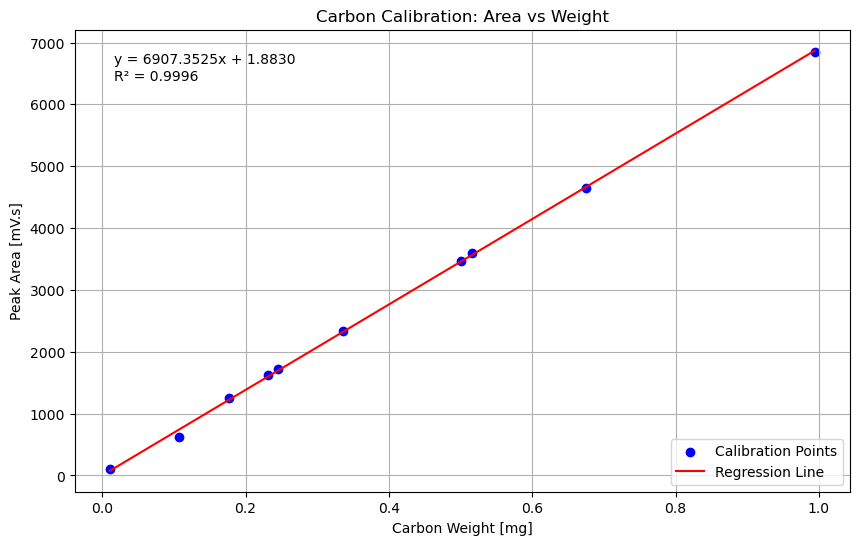


Carbon Quantification Results:
   Primary File  Carbon Area [mV.s]  Carbon Weight [mg]  Carbon Weight [µg]
0           002           2706.5874            0.391569          391.568890
1           003           1409.3142            0.203758          203.758410
2           004           6444.3133            0.932692          932.691684
3           005           3270.2968            0.473179          473.178943
4           015             53.0818            0.007412            7.412213
5           016             37.5432            0.005163            5.162639
6           017            529.9675            0.076453           76.452514
7           018            142.4251            0.020347           20.346735
8           019           2300.6468            0.332800          332.799543
9           020            374.2347            0.053907           53.906568
10          021            110.6932            0.015753           15.752804
11          022             50.0997            0.006980 

In [13]:
cal_file = 'Katz_20141210_P-vent_CTO_Test_cal.csv'
data_file = 'Katz_20141210_P-vent_CTO_Test_data.csv'
calibration_results, quantification_results = carbon_quantification_workflow(cal_file, data_file)

In [34]:
def process_weight_data(weight_file_path):
    """
    Process the weight data file and calculate organic matter loss.
    
    Parameters:
    -----------
    weight_file_path : str
        Path to the weight data CSV file
    
    Returns:
    --------
    pandas.DataFrame: Processed weight data
    """
    # Read the CSV file
    weights_df = pd.read_excel(weight_file_path)
    
    # Convert Primary File to integer
    weights_df['Primary File'] = weights_df['Primary File'].astype(int)
    
    # Calculate organic matter loss (full - after ox)
    weights_df['organic_matter_loss_g/g'] = (weights_df['full'] - weights_df['after ox'])/(weights_df['full'] - weights_df['empty'])
    weights_df['organic_matter_loss_mg/g'] = weights_df['organic_matter_loss_g/g'] * 1000  # Convert to mg
    
    # Keep only necessary columns
    weights_df = weights_df[['Sample', 'Primary File', 'weight', 'organic_matter_loss_g/g', 'organic_matter_loss_mg/g']]
    
    return weights_df

def calculate_concentrations(carbon_results, weights_df):
    """
    Calculate final carbon concentrations by combining carbon quantification
    results with weight data.
    
    Parameters:
    -----------
    carbon_results : pandas.DataFrame
        Results from carbon quantification
    weights_df : pandas.DataFrame
        Processed weight data
    
    Returns:
    --------
    pandas.DataFrame: Final concentration results
    """
    # Convert Primary File to integer in carbon_results
    carbon_results['Primary File'] = pd.to_numeric(carbon_results['Primary File'])
    
    # Merge the dataframes on Primary File
    merged_df = pd.merge(
        weights_df,
        carbon_results,
        left_on='Primary File',
        right_on='Primary File',
        how='inner'
    )
    
    # Calculate concentration (µg C / mg sample)
    merged_df['C_concentration_ug_mg'] = merged_df['Carbon Weight [µg]'] / (merged_df['weight']*(1+merged_df['organic_matter_loss_g/g']))
    
    # Reorder and rename columns
    final_df = merged_df[[
        'Sample',
        'Primary File',
        'weight',
        'Carbon Area [mV.s]',
        'Carbon Weight [µg]',
        'organic_matter_loss_g/g',
        'organic_matter_loss_mg/g',
        'C_concentration_ug_mg'
    ]]
    
    # Round numerical columns
    final_df = final_df.round({
        'weight': 3,
        'Carbon Area [mV.s]': 2,
        'Carbon Weight [µg]': 2,
        'organic_matter_loss_g/g': 3,
        'organic_matter_loss_mg/g': 3,
        'C_concentration_ug_mg': 2
    })
    
    return final_df

def concentration_workflow(cal_file, data_file, weight_file):
    """
    Complete workflow for calculating carbon concentrations.
    
    Parameters:
    -----------
    cal_file : str
        Path to calibration CSV file
    data_file : str
        Path to carbon data CSV file
    weight_file : str
        Path to weight data CSV file
    
    Returns:
    --------
    pandas.DataFrame: Final concentration results
    """
    # Step 1: Get carbon quantification results
    calibration_results, carbon_results = carbon_quantification_workflow(cal_file, data_file)
    
    # Step 2: Process weight data
    weights_df = process_weight_data(weight_file)
    
    # Step 3: Calculate concentrations
    final_results = calculate_concentrations(carbon_results, weights_df)
    
    # Display results
    print("\nFinal Carbon Concentration Results:")
    print(final_results)
    
    # Save results to Excel
    final_results.to_excel('carbon_concentration_results.xlsx', index=False)
    
    return final_results

Calibration Line Parameters:
Slope: 6907.35253728295
Intercept: 1.8830308802221225
R-squared: 0.9995558373076884


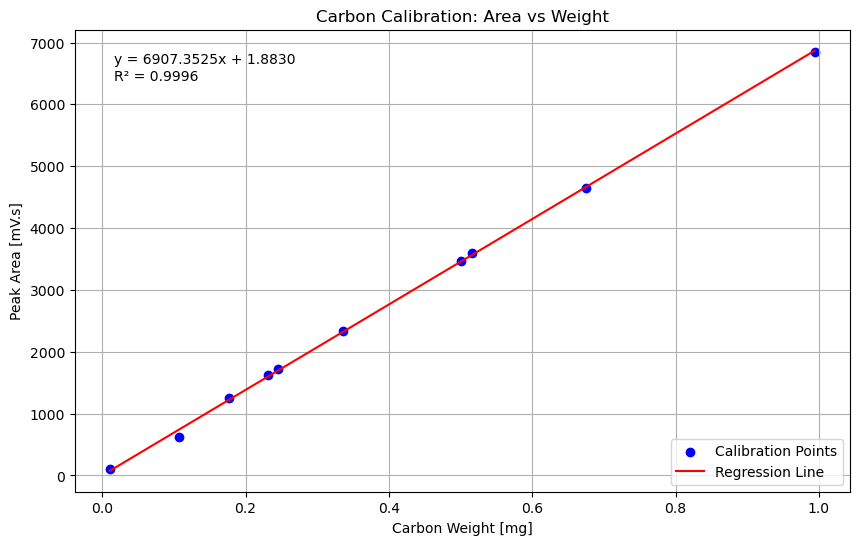


Carbon Quantification Results:
   Primary File  Carbon Area [mV.s]  Carbon Weight [mg]  Carbon Weight [µg]
0           002           2706.5874            0.391569          391.568890
1           003           1409.3142            0.203758          203.758410
2           004           6444.3133            0.932692          932.691684
3           005           3270.2968            0.473179          473.178943
4           015             53.0818            0.007412            7.412213
5           016             37.5432            0.005163            5.162639
6           017            529.9675            0.076453           76.452514
7           018            142.4251            0.020347           20.346735
8           019           2300.6468            0.332800          332.799543
9           020            374.2347            0.053907           53.906568
10          021            110.6932            0.015753           15.752804
11          022             50.0997            0.006980 

In [35]:
weight_file = '20241210 CTO and EA weights.xlsx'

final_results = concentration_workflow(cal_file, data_file, weight_file)